In [103]:
from PIL import Image, ImageFilter
from google.cloud import vision
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import base64
import io
import os

# OCR with Google Vision API

In this notebook we are exploring the performance of Google Vision API. There is a function to recognize handwritten text. The steps to enable the API and authentication are described below (from this [documentation](https://cloud.google.com/vision/docs/handwriting#vision-document-text-detection-python)).
1. Set up a Cloud Console project
    1. Create or select a project
    2. Enable the Vision API for that project
    3. Create a service account
    4. Download a private key as JSON
2. Set the environment variable GOOGLE_APPLICATION_CREDENTIALS to the path of the JSON file. For Linux and macOS:
```
export GOOGLE_APPLICATION_CREDENTIALS="KEY_PATH_TO_JSON_FILE"
```

In [91]:
def detect_text(bytes_img):
    """
    Uses the Google Vision API to extract text from
    an image.
    
    Arguments
    ---------
    file_path: str
               path of the image to process.
    
    Outputs
    -------
    response: AnnotateImageResponse object
              json like format with bounding box and other
              relevant information.
    text: str
          text extracted from the image.
    """
    client = vision.ImageAnnotatorClient()    
    image = vision.Image(content=bytes_img)
    response = client.document_text_detection(image=image)
    text = response.full_text_annotation.text
    
    return response, text

In [104]:
def pillow_to_bytes(pillow_img):
    """
    Converts an image object from pillow to bytes (base64).
    
    Arguments
    ---------
    pillow_img: PIL.Image object
                pillow image object to be converted
    
    Output
    ------
    bytes_img: bytes
               base64 bytes image
    """
    pillow_img = pillow_img.convert("RGB")
    buffer = io.BytesIO()
    pillow_img.save(buffer, format='JPEG')
    bytes_img = base64.b64encode(buffer.getvalue())
    
    return bytes_img

In [93]:
def getbytesimg_from_path(filepath):
    """
    Obtains the bytes base64 format of an image from a 
    local file path.
    
    Arguments
    ---------
    filepath: str
              Path of the image file to convert
    
    Output
    ------
    bytes_img: bytes
               base64 format of the image
    """
    with open(filepath, "rb") as image_file:
        bytes_img = image_file.read()
    
    return bytes_img

In [94]:
def display_imgs(filt=None):
    """
    Display 10 sample images in a 5x2 matrix. 
    
    Arguments
    ---------
        filt: str
            Optional filter to be applied to the images.
            Options: contour, emboss, rank, combined
    
    Output
    ------
        images: list of PIL.Image objects
            A list of the 10 sample images.
    """
    images = []
    fig, axs = plt.subplots(5,2, figsize=(12,6))
    
    for col in range(2):
        for row in range(5):
            img = Image.open(f"ocr_sample_imgs/sample{row+col*5+1}.jpg")            
            
            if filt == "contour":
                img = img.filter(ImageFilter.CONTOUR)
                
            if filt == "emboss":
                img = img.filter(ImageFilter.EMBOSS)
                
            if filt == "rank":
                img = img.filter(ImageFilter.RankFilter(size=3, rank=0))
                
            if filt == "combined":
                img = img.filter(ImageFilter.CONTOUR).convert("L").point(
                                 lambda x: 255 if x > 210 else 0, mode="1")                
            
            images.append(img)
            axs[row][col].imshow(img)
            axs[row][col].axis("off")
            
    return images

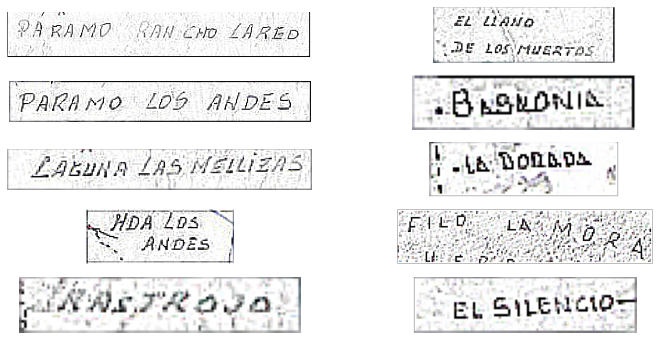

In [73]:
contour_imgs = display_imgs("contour")

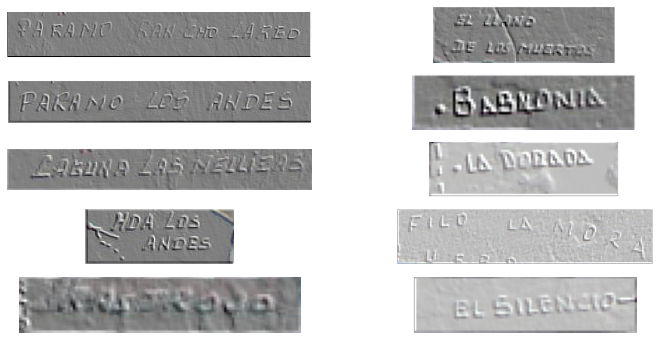

In [74]:
emboss_imgs = display_imgs("emboss")

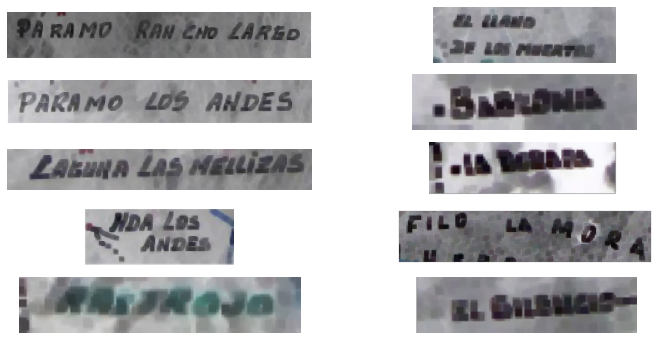

In [75]:
rank_imgs = display_imgs("rank")

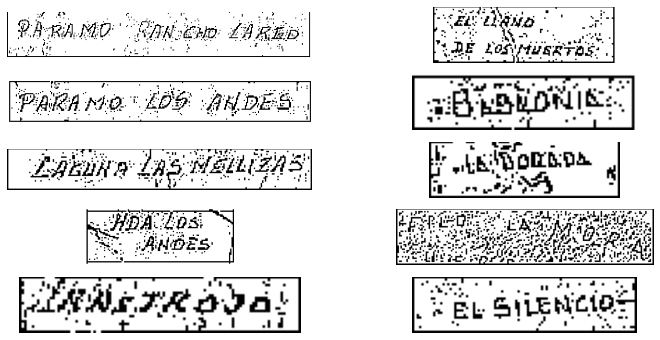

In [76]:
contbw_imgs = display_imgs("combined")

## Text detection with and without filters

### Pandas dataframe

In [87]:
true_labels = ["PÁRAMO RANCHO LARGO", "PÁRAMO LOS ANDES",
               "LAGUNAS LAS MELLIZAS", "HDA LOS ANDES",
               "RASTROJO", "EL LLANO DE LOS MUERTOS",
               "BABILONIA", "LA DORADA", "FILO LA MORA",
               "EL SILENCIO"]
results = pd.DataFrame(dict(True_label=true_labels))
results["Original"] = ""
results["Contour"] = ""
results["Emboss"] = ""
results["Rank"] = ""
results["Contour_BW"] = ""
results

,True_label,Original,Contour,Emboss,Rank,Contour_BW
0,PÁRAMO RANCHO LARGO,,,,,
1,PÁRAMO LOS ANDES,,,,,
2,LAGUNAS LAS MELLIZAS,,,,,
3,HDA LOS ANDES,,,,,
4,RASTROJO,,,,,
5,EL LLANO DE LOS MUERTOS,,,,,
6,BABILONIA,,,,,
7,LA DORADA,,,,,
8,FILO LA MORA,,,,,
9,EL SILENCIO,,,,,


In [89]:
responses_original = []
responses_contour = []
responses_emboss = []
responses_rank = []
responses_contourbw = []

In [101]:
for i in range(10):
    # Original images
    response, text = detect_text(getbytesimg_from_path(f"ocr_sample_imgs/sample{i+1}.jpg"))
    results["Original"].loc[i] = text
    responses_original.append(response)
    
    # Contour images
    response, text = detect_text(pillow_to_bytes(contour_imgs[i]))
    results["Contour"].loc[i] = text
    responses_contour.append(response)
    
    # Emboss images
    response, text = detect_text(pillow_to_bytes(emboss_imgs[i]))
    results["Emboss"].loc[i] = text
    responses_emboss.append(response)
    
    # Rank images    
    response, text = detect_text(pillow_to_bytes(rank_imgs[i]))
    results["Rank"].loc[i] = text
    responses_rank.append(response)
    
    # Contour B&W images
    response, text = detect_text(pillow_to_bytes(contbw_imgs[i]))
    results["Contour_BW"].loc[i] = text
    responses_contourbw.append(response)

### Results of text detection using different filters

In [102]:
results

,True_label,Original,Contour,Emboss,Rank,Contour_BW
0,PÁRAMO RANCHO LARGO,PA RAMO RANCHO LARGO\n,PARAMO RAN CHO LARED\n,1950N/24 CAT_HED\n,PA RAMO RAN CNO ZARED\n,PARAMO RANCHO LARED\n
1,PÁRAMO LOS ANDES,PARAMO LOS ANDES\n,PARAMO LOS ANDES\n,PALAN PES\n,PARAMO LOS ANDES\n,PARAMO 2DS ANDES\n
2,LAGUNAS LAS MELLIZAS,LAGUNA LAS MELLIZAS\n,su217191 547 010767\n,C35219_05 NE:\n=3\n,LAWA LAS MELLIZAS\n,LAGUNA 285 NEZAS\n
3,HDA LOS ANDES,HDA LOS\nANDES\n,HDA LOS\nANDES\n,DA LOS\nANDES\n,NDA Zos\nANDES\n,HDALOS\nANDES .\n
4,RASTROJO,ASTROJA\n,دن کے مالی است که قرار داده ام\n,BALAYEV\n,சான்\n,ROS\n1\n
5,EL LLANO DE LOS MUERTOS,EL LLANO\nDE LOS MUERTOS\n,22 AND\nDE LOS MUERTAS\n,人でないとされた、27日に\nNE\n,22 D\nDE LOS MUERTE\n,SELANO\n-\n' DE LOS MUERTOS:\n
6,BABILONIA,.BAB DNIA\n,BASLONIA\n,VINONEN 9\n,BAJAN\n,BIOMIS\n
7,LA DORADA,6. LA DORADA\n,8. DORADA\n,גם אתה ...\n,LA TRANS\n,.[\nBOLEDA\nR\n.\n
8,FILO LA MORA,FILO\nLA MORA\n,FD\nLA MO\n,FILO\nLANC24\n,FILO\nLA MORA\n,葬管\n
9,EL SILENCIO,EL SILENCIO\n,EL SILENCID-\n,EL SILENCIO\n,Dane 73\n,EL SILENCIOS\n


It seems like detecting text from the original images yields the best results with the sample images.

In [113]:
r, t = detect_text(pillow_to_bytes(rank_imgs[5]))
t

''

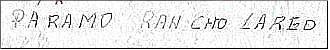

In [107]:
contour_imgs[0]

In [108]:
type(pillow_to_bytes(contour_imgs[0]))

bytes

In [112]:
(getbytesimg_from_path("ocr_sample_imgs/sample1.jpg"))

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\xb4\x00\xb4\x00\x00\xff\xe1\x00\x80Exif\x00\x00MM\x00*\x00\x00\x00\x08\x00\x04\x01\x1a\x00\x05\x00\x00\x00\x01\x00\x00\x00>\x01\x1b\x00\x05\x00\x00\x00\x01\x00\x00\x00F\x01(\x00\x03\x00\x00\x00\x01\x00\x02\x00\x00\x87i\x00\x04\x00\x00\x00\x01\x00\x00\x00N\x00\x00\x00\x00\x00\x00\x00\xb4\x00\x00\x00\x01\x00\x00\x00\xb4\x00\x00\x00\x01\x00\x03\xa0\x01\x00\x03\x00\x00\x00\x01\x00\x01\x00\x00\xa0\x02\x00\x04\x00\x00\x00\x01\x00\x00\x01J\xa0\x03\x00\x04\x00\x00\x00\x01\x00\x00\x002\x00\x00\x00\x00\xff\xed\x008Photoshop 3.0\x008BIM\x04\x04\x00\x00\x00\x00\x00\x008BIM\x04%\x00\x00\x00\x00\x00\x10\xd4\x1d\x8c\xd9\x8f\x00\xb2\x04\xe9\x80\t\x98\xec\xf8B~\xff\xc0\x00\x11\x08\x002\x01J\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\